In [1]:
import argparse
import logging
import pygame
import threading
import numpy as np
from BouncingBall import BouncingBall
from utils import *
from matplotlib import pyplot as plt

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
class BouncingBall:
    def __init__(self, logger, m, R, h, v0,
                 total_time=20.0, dt=0.001, v_term=10.0, k=1000.0):

        self.logger = logger
        self.args = {'m': m, 'R': R, 'h': h, 'v0': v0, 'k': k, 'dt': dt,
                     'g': 9.81, 'D': m * 9.81 / (v_term * v_term)}
        self.angles = np.radians(np.linspace(15, 90, 6))
        self.n_plots = self.angles.shape[0]
        self.n_steps = int(round(total_time / dt))
        self.t = np.linspace(0, total_time, self.n_steps)
        # for lazy calculation
        self._lazy_flag = False
        self.r, self.v = np.zeros((2, self.n_plots, self.n_steps, 2))
        self.Ek, self.Ep, self.Es = np.zeros((3, self.n_plots, self.n_steps,))
        self.logger = logger

        self._calculate()

    def _calc_singleton(self, angle, idx):
        r, v = np.zeros((2, self.n_steps, 2))
        Ek, Ep, Es = np.zeros((3, self.n_steps,))
        # special/init values
        Ek[0] = 0.5 * self.args['m'] * (np.linalg.norm(self.args['v0']) ** 2)
        Ep[0] = self.args['m'] * self.args['g'] * self.args['h']
        Es[-1] = 0
        r[0] = np.asarray([0, self.args['h']])
        v[0] = self.args['v0'] * np.asarray([np.cos(angle), np.sin(angle)])
        for i in range(self.n_steps - 1):
            if r[i, 1] < self.args['R']:
                # contact with the ground
                N = self.args['k'] * (self.args['R'] - r[i, 1]) * np.asarray([0, 1])
                E = 0.5 * self.args['k'] * ((self.args['R'] - r[i, 1]) ** 2)
            else:
                # no contact with the ground
                N = np.asarray([0, 0])
                E = 0
            # estimation step
            Fd = -self.args['D'] * np.linalg.norm(v[i]) * v[i]
            G = -self.args['m'] * self.args['g'] * np.asarray([0, 1])
            F_total = N + Fd + G
            a = F_total / self.args['m']
            # update step (Euler-Cromer)
            v[i + 1] = v[i] + a * self.args['dt']
            r[i + 1] = r[i] + v[i + 1] * self.args['dt']
            Ek[i + 1] = 0.5 * self.args['m'] * (np.linalg.norm(v[i + 1]) ** 2)
            Ep[i + 1] = self.args['m'] * self.args['g'] * r[i + 1][1]
            Es[i] = E

        self.r[idx], self.v[idx] = r, v
        self.Ek[idx], self.Ep[idx], self.Es[idx] = Ek, Ep, Es
        self.logger.info('Plot #{} has been calculated'.format(idx))

    def _calculate(self):
        if self._lazy_flag is False:
            self._lazy_flag = True
            for i in range(self.n_plots):
                self._calc_singleton(self.angles[i], i)
            self.logger.info('Singletons have been calculated')

    def plot_r(self, ax, idx=None):
        if idx is not None:
            angle = np.round(np.degrees(self.angles[idx]), 0)
            ax.plot(self.r[idx][:, 0], self.r[idx][:, 1], label='{}'.format(angle))
            self.logger.info('plot_r #{} has been calculated'.format(idx))
        else:
            for i in range(self.n_plots):
                angle = np.round(np.degrees(self.angles[i]), 0)
                ax.plot(self.r[i][:, 0], self.r[i][:, 1], label='{}'.format(angle), linewidth=0.75)
            self.logger.info('Comparison plot_r has been calculated')

    def plot_E(self, ax, idx):
        angle = np.round(np.degrees(self.angles[idx]), 0)
        ax.plot(self.r[idx][:, 0], self.Ek[idx], 'r', linestyle='-.', label='Ek', linewidth=0.5)
        ax.plot(self.r[idx][:, 0], self.Ep[idx], 'g', linestyle='-.', label='Ep', linewidth=0.5)
        ax.plot(self.r[idx][:, 0], self.Es[idx], 'b', linestyle='-.', label='Es', linewidth=0.5)
        ax.plot(self.r[idx][:, 0], self.Ek[idx] + self.Ep[idx] + self.Es[idx], 'k-', label='E_sum', linewidth=1.5)
        self.logger.info('plot_E #{} has been calculated'.format(idx))

    def plot_xy(self, ax, idx):
        angle = np.round(np.degrees(self.angles[idx]), 0)
        ax.plot(self.t, self.r[idx][:, 0], 'r', linestyle='-', label='x')
        ax.plot(self.t, self.r[idx][:, 1], 'g', linestyle='-', label='y')
        self.logger.info('plot_xy #{} has been calculated'.format(idx))

    def simulation(self, indices):
        WIDTH, HEIGHT = 1280, 520
        COLORS = [(0, 0, 255),  # blue
                  (255, 128, 0),  # orange
                  (0, 255, 0),  # green
                  (255, 0, 0),  # red
                  (128, 0, 128),  # violet
                  ]

        pygame.init()
        pygame.display.set_caption('Bouncing ball simulation')
        screen = pygame.display.set_mode([WIDTH, HEIGHT])
        font = pygame.font.Font('C:\\Windows\\Fonts\\consola.ttf', 14)
        clock = pygame.time.Clock()
        x_scale = max([self.r[idx][:, 0][-1] for idx in indices]) + 0.25
        y_scale = max([np.max(self.r[idx][:, 1]) for idx in indices]) + 0.25

        def prepare_screen():
            screen.fill((0, 0, 0))
            OFFSET_X, OFFSET_Y, OFFSET_F = 120, 50, 30
            for idx in indices:
                angle = np.round(np.degrees(self.angles[idx]), 0)
                text = font.render('{}'.format(angle), True, (255, 255, 255), (0, 0, 0))
                text_rect = text.get_rect()
                text_rect.center = (WIDTH - OFFSET_X + OFFSET_F, OFFSET_Y + 20 * (idx + 1))
                screen.blit(text, text_rect)
                pygame.draw.circle(screen, COLORS[idx], [WIDTH - OFFSET_X, OFFSET_Y + 20 * (idx + 1)], 4)

        # simulation is endless; only user can be stop it
        done = False
        while not done:
            prepare_screen()
            step, n_drawn = 25, 25
            while n_drawn < self.n_steps:
                for idx in indices:
                    pygame.event.pump()
                    for event in pygame.event.get():
                        if event.type == pygame.QUIT:
                            n_drawn = self.n_steps
                            done = True
                            self.logger.info('User has stopped simulation')

                    sub_x = self.r[idx][:, 0][n_drawn - step: n_drawn]
                    sub_y = self.r[idx][:, 1][n_drawn - step: n_drawn]
                    for i, _ in enumerate(sub_x):
                        x, y = int(sub_x[i] * WIDTH / x_scale), int(sub_y[i] * HEIGHT / y_scale)
                        y = HEIGHT - y
                        pygame.draw.circle(screen, COLORS[idx], [x, y], 0)

                n_drawn = n_drawn + step
                clock.tick(60)
                pygame.display.flip()

        pygame.quit()
        self.logger.info('Simulation has ended')

In [3]:
def singleton_plot(ball, idx):
    f = plt.figure(num='Singleton')
    # xy plot
    ax_xy = f.add_subplot(2, 2, 1)
    plt.xlabel('t [s]')
    plt.ylabel('x, y [m]')
    plt.title('r / t')
    ball.plot_xy(ax_xy, idx)
    plt.legend()
    # E plot
    ax_E = f.add_subplot(2, 2, 2)
    plt.xlabel('x [m]')
    plt.ylabel('E [J]')
    plt.title('E / x')
    ball.plot_E(ax_E, idx)
    plt.legend()
    # r plot
    ax_r = f.add_subplot(2, 1, 2)
    plt.xlabel('x [m]')
    plt.ylabel('y [m]')
    plt.title('r (x, y)')
    ball.plot_r(ax_r, idx)
    plt.legend()


def comparison_plot(ball):
    f = plt.figure(num='Comparison')
    ax = f.add_subplot(1, 1, 1)
    plt.xlabel('x [m]')
    plt.ylabel('y [m]')
    plt.title('r (x, y)')
    ball.plot_r(ax)
    plt.legend()


def simulation(ball, indices):
    '''
    #REQ: 'Indices' is a list.
    '''

    ball.simulation(indices)

2019-05-26 00:02:09,453 INFO: Plot #0 has been calculated
2019-05-26 00:02:10,132 INFO: Plot #1 has been calculated
2019-05-26 00:02:10,814 INFO: Plot #2 has been calculated
2019-05-26 00:02:11,497 INFO: Plot #3 has been calculated
2019-05-26 00:02:12,180 INFO: Plot #4 has been calculated
2019-05-26 00:02:12,863 INFO: Plot #5 has been calculated
2019-05-26 00:02:12,864 INFO: Singletons have been calculated
2019-05-26 00:02:12,884 INFO: plot_xy #3 has been calculated
2019-05-26 00:02:12,909 INFO: plot_E #3 has been calculated
2019-05-26 00:02:12,928 INFO: plot_r #3 has been calculated
2019-05-26 00:02:12,958 INFO: Comparison plot_r has been calculated


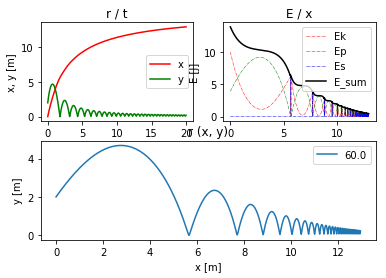

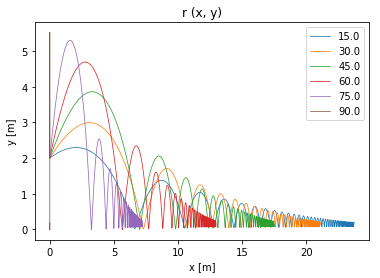

In [6]:
logging.basicConfig(level=logging.INFO, format='%(asctime)23s %(levelname)s: %(message)s')
logger = logging.getLogger(__name__)
ball = BouncingBall(logger, 0.2, 0.1, 2.0, 10.0)

singleton_plot(ball, 3)
comparison_plot(ball)
# thread = threading.Thread(target=simulation, args=(ball, [0, 1, 2, 3, 4]))
# thread.daemon = True
# thread.start()
plt.show()

In [7]:
simulation(ball, [3])

2019-05-26 00:02:31,092 INFO: User has stopped simulation
2019-05-26 00:02:31,352 INFO: Simulation has ended
